#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


* 단계별로 나눠서 모델링을 수행  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, concatenate
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 0) 함수 제작

In [5]:
# 가장 기본적인 pipeline
def data01_pipeline(df):
  df.drop(columns='subject', inplace=True)

  scaler = MinMaxScaler()
  df = scaler.fit_transform(df)

  return df

# STANDING, SITTING, LAYING, WALKING, WALKING-UPSTAIRS, WALKING-DOWNSTAIRS
# LabelEncoder 방식으로 변환
def data01_pipeline_activity(df):
  x = df.drop(columns='Activity')
  y = df.loc[:, ['Activity']]

  df = data01_pipeline(x)

  lenc = LabelEncoder()
  y['Activity'] = lenc.fit_transform(y['Activity'])
  return df, y['Activity'], lenc.classes_

# Activity 기준으로 is_dynamic 변환
def data01_pipeline_is_dynamic(df):
  x = df.drop(columns='Activity')
  y = df.loc[:, ['Activity']]

  df = data01_pipeline(x)

  y['is_dynamic'] = y['Activity'].apply(lambda x : 1 if x in ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS') else 0)
  y.drop(columns=['Activity'], inplace=True)

  return df, y['is_dynamic']

# is_dynamic, Activity 전부 출력
def data01_pipeline_all(df):
  x = df.drop(columns='Activity')
  y = df.loc[:, ['Activity']]

  df = data01_pipeline(x)

  y['is_dynamic'] = y['Activity'].apply(lambda x : 1 if x in ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS') else 0)

  lenc = LabelEncoder()
  y['Activity'] = lenc.fit_transform(y['Activity'])
  return df, y['Activity'], lenc.classes_, y['is_dynamic']

# is_dynamic에 따라 분리를 위한 함수
def devide_is_dynamic(df, activity, is_dynamic):
  result = pd.concat([pd.DataFrame(df), activity, is_dynamic], axis=1)
  dynamic = result.loc[(is_dynamic == 1)]
  dynamic_x = dynamic.drop(columns=['Activity', 'is_dynamic'])
  dynamic_y = dynamic.loc[:, 'Activity']

  static = result.loc[(is_dynamic == 0)]
  static_x = static.drop(columns=['Activity', 'is_dynamic'])
  static_y = static.loc[:, 'Activity']


  return dynamic_x, dynamic_y, static_x, static_y

# Loop 테스트 함수
def loop_fit_test(param, x_train, y_train, x_val, y_val, loop_count=5, learning_rate=0.001, epochs=100, validation_split=0.2, es_info=None, verbose='auto'):
  result = []
  history_list = []
  model_list = []
  for i in range(loop_count):
    clear_session()
    model = Sequential(eval(param))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy')
    es = None if es_info is None else [EarlyStopping(monitor=es_info['monitor'], min_delta=es_info['min_delta'], patience=es_info['patience'])]
    history = model.fit(x_train, y_train, epochs=epochs, verbose=verbose, validation_split=validation_split, callbacks=es).history
    pred = model.predict(x_val)
    pred = pred.argmax(axis=1)
    result.append({
        'accuracy_score' : accuracy_score(y_val, pred),
        'confusion_matrix' : confusion_matrix(y_val, pred),
        'classification_report' : classification_report(y_val, pred)
    })
    history_list.append(history)
    model_list.append(model)
    print(f"{i+1} 번쨰 학습 Accuracy_score : {result[-1]['accuracy_score']}")
  return result, history_list, model_list

#### 1) 데이터로딩

In [6]:
original_data = pd.read_csv(path + 'data01_train.csv')

#### 2) 기본 정보 조회

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [227]:
x, y_activity, classes, y_is_dynamic = data01_pipeline_all(original_data.copy())
dynamic_x, dynamic_y, static_x, static_y = devide_is_dynamic(x, y_activity, y_is_dynamic)

### (2) x, y 분리

In [228]:
# 함수화 진행
classes

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
# 함수화 진행

### (4) 데이터 분할
* train, val 분할

In [37]:
# activity 분할
x_train, x_val, y_train, y_val = train_test_split(x, y_activity, test_size=0.3, random_state=20)

# is_dynamic 분할
x_train2, x_val2, y_train2, y_val2 = train_test_split(x, y_is_dynamic, test_size=0.3, random_state=20)

# 정적 데이터 분할
x_train_static, x_val_static, y_train_static, y_val_static = train_test_split(static_x, static_y, test_size=0.3, random_state=20)

# 동적 데이터 분할
x_train_dynamic, x_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(dynamic_x, dynamic_y, test_size=0.3, random_state=20)

In [108]:
x_train.shape
x_train_dynamic.shape

(1852, 561)

## **3.단계별 모델링**

### (0) 글로벌 변수

In [9]:
result_dict = {}
history_dict = {}

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [29]:
#모델 선언
model1 = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
history1 = model1.fit(x_train2, y_train2, epochs=100, verbose=0, validation_split=0.2).history
pred1 = model1.predict(x_val2)
# pred1 = pred1.argmax(axis=1)
pred1 = np.where(pred1 >= 0.5, 1, 0)
result1 = {
    'accuracy_score' : accuracy_score(y_val2, pred1),
    'confusion_matrix' : confusion_matrix(y_val2, pred1),
    'classification_report' : classification_report(y_val2, pred1)
}
result_dict['Model1'] = [result1, history1]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [35]:
print(result_dict['Model1'][0]['confusion_matrix'])
print(result_dict['Model1'][0]['classification_report'])

[[956   0]
 [  0 809]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       956
           1       1.00      1.00      1.00       809

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



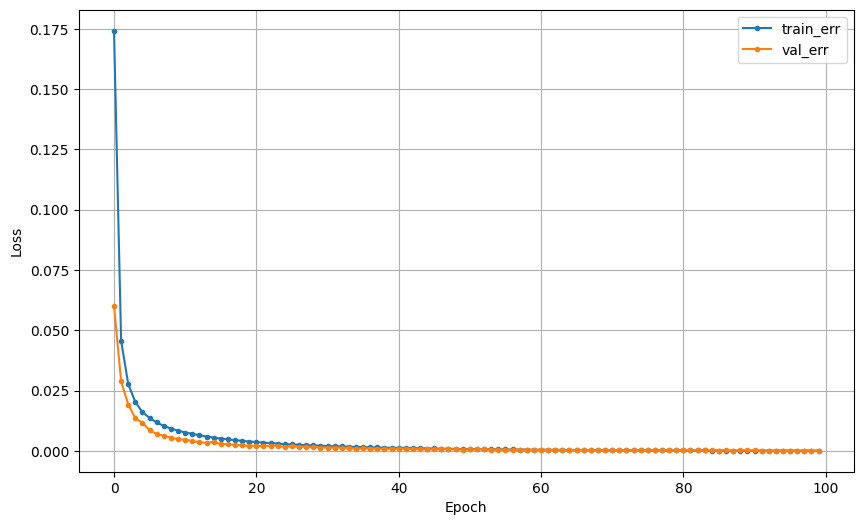

In [32]:
dl_history_plot(result_dict['Model1'][1])

#### 2) 모델2

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

##### 1> 정적 동작 세부 분류 1번

In [245]:
#모델 선언
model2 = Sequential([
  Input(shape=(x_train.shape[1],)),
  Dense(512, activation='relu'),
  Dropout(0.2),
  Dense(256, activation='relu'),
  Dropout(0.2),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(3, activation='softmax')
])
# 256을 512로 바꾸고, 32 하나 제거
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20)
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')
history2 = model2.fit(x_train_static, y_train_static, epochs=1000, validation_split=0.2, callbacks=[es]).history
pred2 = model2.predict(x_val_static)
pred2 = pred2.argmax(axis=1)
# pred1 = np.where(pred1 >= 0.5, 1, 0)
result2 = {
    'accuracy_score' : accuracy_score(y_val_static, pred2),
    'confusion_matrix' : confusion_matrix(y_val_static, pred2),
    'classification_report' : classification_report(y_val_static, pred2)
}
result_dict['Model2'] = [result2, history2]

Epoch 1/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0456 - val_loss: 0.7169
Epoch 2/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7400 - val_loss: 0.4583
Epoch 3/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5104 - val_loss: 0.3786
Epoch 4/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4425 - val_loss: 0.3133
Epoch 5/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4040 - val_loss: 0.3146
Epoch 6/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3318 - val_loss: 0.2558
Epoch 7/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2930 - val_loss: 0.2231
Epoch 8/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2646 - val_loss: 0.2042
Epoch 9/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2589 - val_loss: 0.1908
Epoch 10/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2052 - val_loss: 0.2484
Epoch 11/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2254 - val_loss: 0.1614
Epoch 12/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10

In [243]:
print(result_dict['Model2'][0]['accuracy_score'])
print(result_dict['Model2'][0]['confusion_matrix'])
print(result_dict['Model2'][0]['classification_report'])

0.9824922760041195
[[338   0   0]
 [  0 300   8]
 [  0   9 316]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       338
           1       0.97      0.97      0.97       308
           2       0.98      0.97      0.97       325

    accuracy                           0.98       971
   macro avg       0.98      0.98      0.98       971
weighted avg       0.98      0.98      0.98       971



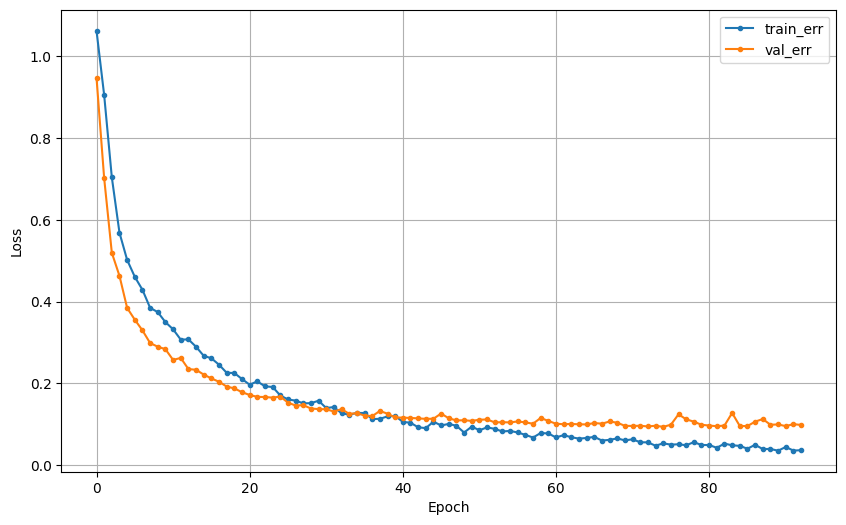

In [136]:
dl_history_plot(result_dict['Model2'][1])

##### 2> 정적 동작 세부 분류 2

In [102]:
def func_dl_process(x_train, x_val, y_train, y_val):
  x_train = pd.DataFrame(x_train)
  x_val = pd.DataFrame(x_val)

  # 다중입력 모델링 (가속도, 각속도, angle센서(중력가속도와 각속도 등등의 벡터))
  # 'Acc'가 포함되면서 'angle'이 포함되지 않은 컬럼을 선택하여 x_train1에 저장
  x_train1 = x_train.filter(like='Acc').filter(regex='^(?!.*angle).*$', axis=1)
  x_val1 = x_val.filter(like='Acc').filter(regex='^(?!.*angle).*$', axis=1)

  # 'Gyro'가 포함되면서 'angle'이 포함되지 않은 컬럼을 선택하여 x_train2에 저장
  x_train2 = x_train.filter(like='Gyro').filter(regex='^(?!.*angle).*$', axis=1)
  x_val2 = x_val.filter(like='Gyro').filter(regex='^(?!.*angle).*$', axis=1)

  # 'angle' 컬럼  x_train3에 저장
  x_train3 = x_train.drop(columns=x_train1.columns).drop(columns=x_train2.columns)
  x_val3 = x_val.drop(columns=x_val1.columns).drop(columns=x_val2.columns)

  #입력
  input_1 = Input(shape=(x_train1.shape[1],),name='input_1')
  input_2 = Input(shape=(x_train2.shape[1],),name='input_2')
  input_3 = Input(shape=(x_train3.shape[1],),name='input_3')

  # 첫번째 입력을 위한 레이어
  hl1_1=Dense(50,activation='relu')(input_1)
  hl1_2=Dense(50,activation='relu')(input_2)
  hl1_3=Dense(10,activation='relu')(input_3)

  #세 히든레이어 결함
  cbl = concatenate([hl1_1,hl1_2,hl1_3])

  #추가 히든레이어
  hl2 = Dense(32,activation='relu')(cbl)
  hl3 = Dense(16,activation='relu')(hl2)

  #출력
  output = Dense(6,activation='softmax')(hl3)

  #모델 선언
  model = Model(inputs=[input_1,input_2,input_3],outputs = output)

  model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy')
  history = model.fit([x_train1, x_train2, x_train3], y_train, epochs=100, verbose=0, validation_split=0.2).history
  pred = model.predict([x_val1, x_val2, x_val3])
  pred = pred.argmax(axis=1)
  result = {
      'accuracy_score' : accuracy_score(y_val, pred),
      'confusion_matrix' : confusion_matrix(y_val, pred),
      'classification_report' : classification_report(y_val, pred)
  }
  return model, result, history

In [103]:
model2_2, result2_2, history2_2 = func_dl_process(x_train_static, x_val_static, y_train_static, y_val_static)
result_dict['Model2_2'] = [result2_2, history2_2]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [104]:
print(result_dict['Model2_2'][0]['accuracy_score'])
print(result_dict['Model2_2'][0]['confusion_matrix'])
print(result_dict['Model2_2'][0]['classification_report'])

0.9773429454170958
[[338   0   0]
 [  0 298  10]
 [  0  12 313]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       338
           1       0.96      0.97      0.96       308
           2       0.97      0.96      0.97       325

    accuracy                           0.98       971
   macro avg       0.98      0.98      0.98       971
weighted avg       0.98      0.98      0.98       971



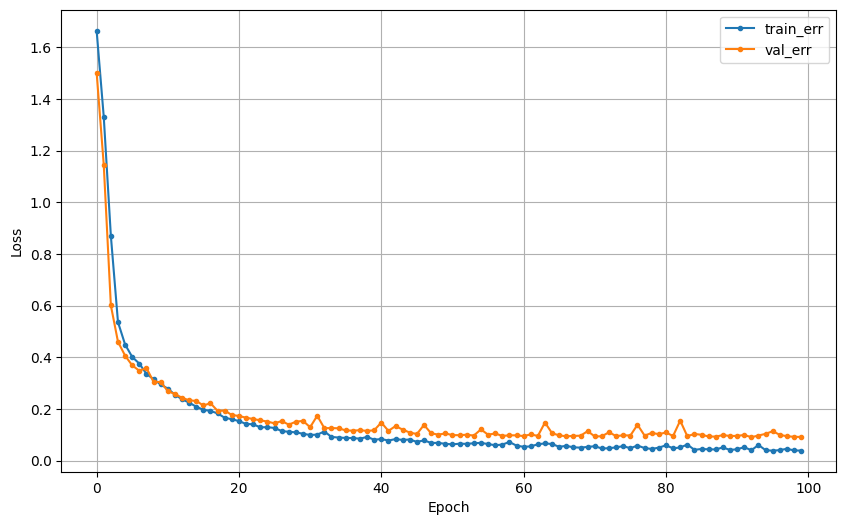

In [105]:
dl_history_plot(result_dict['Model2_2'][1])

#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [74]:
t_y_train_dynamic = y_train_dynamic-3
t_y_val_dynamic = y_val_dynamic-3

In [238]:
#모델 선언
model3 = Sequential([
  Input(shape=(x_train.shape[1],)),
  Dense(256, activation='relu'),
  Dropout(0.2),
  Dense(256, activation='relu'),
  Dropout(0.2),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(32, activation='relu'),
  Dropout(0.2),
  Dense(3, activation='softmax')
])
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20)
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')
history3 = model3.fit(x_train_dynamic, t_y_train_dynamic, epochs=500, validation_split=0.2, callbacks=[es]).history
pred3 = model3.predict(x_val_dynamic)
pred3 = pred3.argmax(axis=1)
# pred1 = np.where(pred1 >= 0.5, 1, 0)
result3 = {
    'accuracy_score' : accuracy_score(t_y_val_dynamic, pred3),
    'confusion_matrix' : confusion_matrix(t_y_val_dynamic, pred3),
    'classification_report' : classification_report(t_y_val_dynamic, pred3)
}
result_dict['Model3'] = [result3, history3]

Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.1059 - val_loss: 1.0645
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0633 - val_loss: 0.9700
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9820 - val_loss: 0.8225
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8547 - val_loss: 0.6553
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7111 - val_loss: 0.4661
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5429 - val_loss: 0.3343
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4252 - val_loss: 0.2672
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3249 - val_loss: 0.2336
Epoch 9/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2847 - val_loss: 0.2146
Epoch 10/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2363 - val_loss: 0.1816
Epoch 11/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2087 - val_loss: 0.1441
Epoch 12/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

In [235]:
print(result_dict['Model3'][0]['accuracy_score'])
print(result_dict['Model3'][0]['confusion_matrix'])
print(result_dict['Model3'][0]['classification_report'])

0.9886792452830189
[[289   3   1]
 [  1 240   0]
 [  2   2 257]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       293
           1       0.98      1.00      0.99       241
           2       1.00      0.98      0.99       261

    accuracy                           0.99       795
   macro avg       0.99      0.99      0.99       795
weighted avg       0.99      0.99      0.99       795



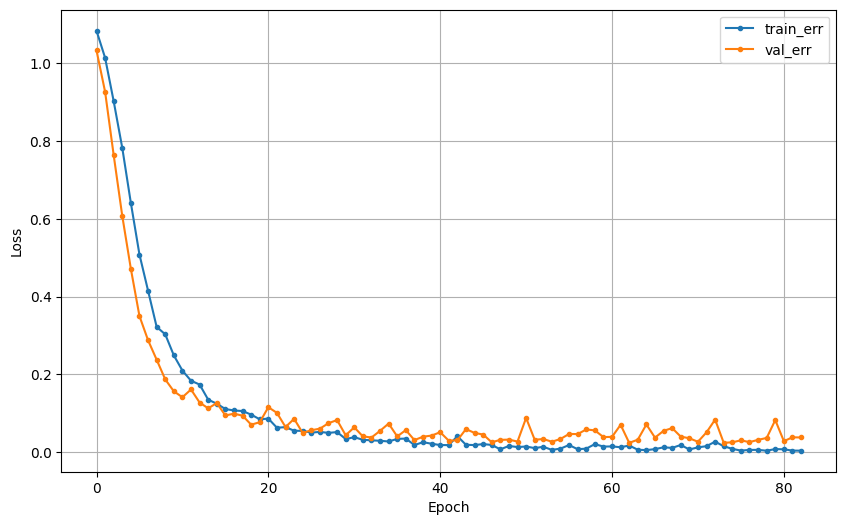

In [236]:
dl_history_plot(result_dict['Model3'][1])

### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [232]:
def func_predict(df):
  global model1, model2, model3

  data = df.copy()
  x, y_activity, classes = data01_pipeline_activity(data)

  pred1 = model1.predict(x)
  pred1 = np.where(pred1 >= 0.5, 1, 0)

  t1 = pd.DataFrame(x)
  t2 = pd.DataFrame(pred1)
  t2 = pd.concat([t2, y_activity], axis=1)
  t2.columns = ["is_activity", 'activity']
  temp = pd.concat([t1, t2], axis=1)

  dynamic = temp.loc[(temp['is_activity'] == 1)]
  dynamic_x = dynamic.drop(columns=['is_activity', 'activity'])

  static = temp.loc[(temp['is_activity'] == 0)]
  static_x = static.drop(columns=['is_activity', 'activity'])

  pred2 = model2.predict(static_x)
  pred2 = pred2.argmax(axis=1)
  pred3 = model3.predict(dynamic_x)
  pred3 = pred3.argmax(axis=1)
  pred3 = pred3 + 3

  pred_list = np.concatenate([pred2, pred3])
  activity_list = pd.concat([static.loc[:, 'activity'], dynamic.loc[:, 'activity']], axis=0)

  print(confusion_matrix(pred_list, activity_list))
  print(classification_report(pred_list, activity_list))

  return pred_list, accuracy_score(pred_list, activity_list), classes

(1471,)
(1471, 563)


#### 2) test 셋으로 예측하고 평가하기

In [152]:
test_data = pd.read_csv(path + 'data01_test.csv')

In [246]:
return_data = func_predict(test_data)
print(return_data[1])

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[292   0   0   0   0   0]
 [  0 248  18   0   0   0]
 [  0   6 269   0   0   0]
 [  0   0   0 225   1   8]
 [  0   0   0   2 194   2]
 [  0   0   0   1   0 205]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.98      0.93      0.95       266
           2       0.94      0.98      0.96       275
           3       0.99      0.96      0.97       234
           4       0.99      0.98      0.99       198
           5       0.95      1.00      0.97       206

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471

0.9741672331747111
